In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jpholiday

In [2]:
df = pd.read_excel('/Users/hiraokatatsuru/Library/CloudStorage/OneDrive-個人用/ドキュメント/物数データ.xlsx')
df.set_index('date', inplace=True)

In [3]:
df

,通常物数
date,
2021-10-01,63000
2021-10-02,0
2021-10-03,0
2021-10-04,102000
2021-10-05,45000
...,...
2025-05-27,29000
2025-05-28,32000
2025-05-29,36000


In [4]:
# 月ごとに分ける
df['month'] = df.index.month

In [5]:
# お盆フラグを作成（例: 8月10日〜8月20日）
#df['is_obon'] = ((df.index.month == 8) & (df.index.day >= 10) & (df.index.day <= 20)).astype(int)
# お盆フラグ（8月13〜17日、土日祝を除く）
df['is_obon'] = (
    (df.index.month == 8) & 
    (df.index.day >= 10) & 
    (df.index.day <= 20)).astype(int)

In [6]:
# 年末年始フラグ（12月29〜1月5日、土日祝を除く）
df['is_new_year'] = (
    (((df.index.month == 12) & (df.index.day >= 26)) | 
     ((df.index.month == 1) & (df.index.day <= 10)))).astype(int)

In [7]:
# 祝日フラグを数値型（1: 祝日、0: 平日）に変換
# まず jpholiday で祝日判定
df['is_holiday'] = df.index.map(lambda x: int(jpholiday.is_holiday(x)))

In [8]:
df['is_after_holiday'] = (
        (df['is_holiday'].shift(1) == 1) & 
        (df['is_holiday'] == 0)
    ).astype(int)
    
# 前日が "祝日明け" フラグ == 1 かつ 当日は祝日ではない → "祝日明けの翌日"
df['is_after_after_holiday'] = (
    (df['is_after_holiday'].shift(1) == 1) &
    (df['is_holiday'] == 0)
).astype(int)

In [54]:
df_work = df[~df.index.weekday.isin([5, 6])].copy()

In [60]:
df_work

,通常物数,month,is_obon,is_new_year,is_holiday,is_after_holiday,is_after_after_holiday,lag_1,lag_5,rolling_mean_5,dow_sin,dow_cos
date,,,,,,,,,,,,
2021-10-08,71000,10,0,0,0,0,0,58000.0,63000.0,64600.0,-0.433884,-0.900969
2021-10-11,96000,10,0,0,0,0,0,71000.0,102000.0,66200.0,0.000000,1.000000
2021-10-12,51000,10,0,0,0,0,0,96000.0,45000.0,65000.0,0.781831,0.623490
2021-10-13,49000,10,0,0,0,0,0,51000.0,55000.0,66200.0,0.974928,-0.222521
2021-10-14,63000,10,0,0,0,0,0,49000.0,58000.0,65000.0,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-26,75000,5,0,0,0,0,0,37000.0,86000.0,43200.0,0.000000,1.000000
2025-05-27,29000,5,0,0,0,0,0,75000.0,28000.0,41000.0,0.781831,0.623490
2025-05-28,32000,5,0,0,0,0,0,29000.0,29000.0,41200.0,0.974928,-0.222521


In [56]:
#過去1日の郵便物数（lag_1）を追加
df_work['lag_1'] = df_work['通常物数'].shift(1)

# 過去5日の郵便物数（lag_5）を追加
df_work['lag_5'] = df_work['通常物数'].shift(5)

In [57]:
df_work['rolling_mean_5'] = (
    df_work['通常物数']
    .shift(1)            # 今日を含めない
    .rolling(window=5)   # ５営業日
    .mean()
)

In [58]:
# 2. dow（0=月曜…6=日曜）を取得
df_work['dow'] = df_work.index.dayofweek

# 3. サイン／コサイン変換
df_work['dow_sin'] = np.sin(2 * np.pi * df_work['dow'] / 7)
df_work['dow_cos'] = np.cos(2 * np.pi * df_work['dow'] / 7)

# 4. 不要なら元の dow 列を削除
df_work.drop(columns=['dow'], inplace=True)

In [59]:
# NaN の行を一括で削除
df_work = df_work.dropna().copy()

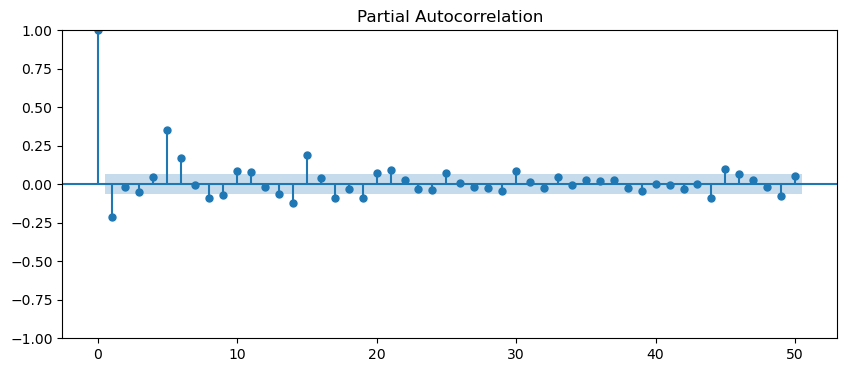

In [64]:
from statsmodels.graphics.tsaplots import plot_pacf
y = df_work['通常物数']

fig, ax = plt.subplots(figsize=(10,4))
plot_pacf(y, ax=ax, lags=50)  # ラグ40までなど任意で設定
plt.show()

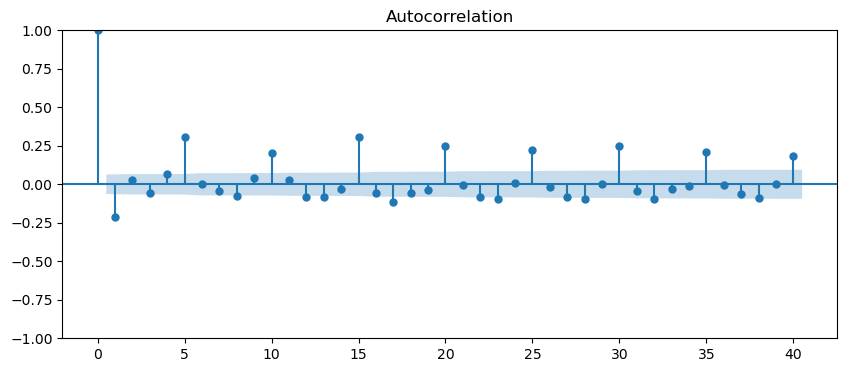

In [62]:
from statsmodels.graphics.tsaplots import plot_acf
y = df_work['通常物数']

fig, ax = plt.subplots(figsize=(10,4))
plot_acf(y, ax=ax, lags=40)  # ラグ40までなど任意で設定
plt.show()

In [65]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ------------------------------------------------------------------------------
# 1. 特徴量と目的変数の準備
# ------------------------------------------------------------------------------
feature_columns = [
    'dow_sin', 'dow_cos',   
    'is_after_holiday',
    'is_after_after_holiday',
    'month',
    'lag_1',
    'lag_5',
    'rolling_mean_5',
    'is_new_year',
    'is_obon',
]

X = df_work[feature_columns].copy()
y = df_work['通常物数'].copy()

# ------------------------------------------------------------------------------
# 2. 時系列分割の設定
# ------------------------------------------------------------------------------
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# ------------------------------------------------------------------------------
# 3. 各 Fold で学習・検証
# ------------------------------------------------------------------------------
model_dt = DecisionTreeRegressor(
    max_depth=5,
    random_state=42
)

mae_list = []
rmse_list = []

for fold_index, (train_idx, val_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # 学習
    model_dt.fit(X_train, y_train)
    
    # 検証データで予測
    y_pred = model_dt.predict(X_val)
    
    # 評価指標を計算
    mae  = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae_list.append(mae)
    rmse_list.append(rmse)
    
    print(f"Fold {fold_index}: MAE = {mae:.2f}, RMSE = {rmse:.2f}")

# ------------------------------------------------------------------------------
# 4. Cross-Validation 結果の平均を出力
# ------------------------------------------------------------------------------
print("\n===== Cross-Validation Result (TimeSeriesSplit) =====")
print(f"Average MAE : {np.mean(mae_list):.2f}")
print(f"Average RMSE: {np.mean(rmse_list):.2f}")


Fold 1: MAE = 9299.53, RMSE = 16460.05
Fold 2: MAE = 10748.32, RMSE = 21339.06
Fold 3: MAE = 10441.36, RMSE = 18971.63
Fold 4: MAE = 11136.34, RMSE = 20164.84
Fold 5: MAE = 10791.49, RMSE = 18120.71

===== Cross-Validation Result (TimeSeriesSplit) =====
Average MAE : 10483.41
Average RMSE: 19011.26


In [66]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3, 5, 7, 9],
    "min_samples_leaf": [1, 5, 10, 20],
    "min_samples_split": [2, 5, 10, 20],
}
# TimeSeriesSplit を CV に使う
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1
)
grid.fit(X, y)
print("Best params:", grid.best_params_)
print("Best RMSE:", -grid.best_score_)


Best params: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 20}
Best RMSE: 19000.112292680882


In [67]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import jpholiday

# ────────────────────────────────────────────────────────
# 前提：df_work が
#   ・日付インデックス
#   ・'通常物数'
#   ・feature_columns = [
#       'dow_sin','dow_cos',
#       'is_after_holiday','is_after_after_holiday',
#       'month','lag_1','lag_5','rolling_mean_5','is_new_year','is_obon'
#     ] の列を持っている
# ────────────────────────────────────────────────────────

X = df_work[feature_columns]
y = df_work['通常物数']

# 1. 最適パラメータでモデル定義
best_params = {
    'max_depth': 5,
    'min_samples_leaf': 5,
    'min_samples_split': 20,
    'random_state': 42
}
model_final = DecisionTreeRegressor(**best_params)

# 2. 全データで再学習
model_final.fit(X, y)

# 3. 自己評価
y_pred_all = model_final.predict(X)
mae_all  = mean_absolute_error(y, y_pred_all)
rmse_all = np.sqrt(mean_squared_error(y, y_pred_all))
print(f"Training MAE : {mae_all:.2f}")
print(f"Training RMSE: {rmse_all:.2f}")

# 4. 翌日予測
#    - next_date: 学習に使った最後の営業日から1営業日後
#    - 土日は 0
last_bd = df_work.index[-1]
# pandas の BDay で「営業日＋祝日も含まない」場合はカスタム。ここは簡易に +1日→ループ検査
next_date = last_bd + pd.Timedelta(days=1)
while next_date.weekday() >= 5 or jpholiday.is_holiday(next_date):
    next_date += pd.Timedelta(days=1)

# 特徴量生成の例
feat = {
    'dow_sin':   np.sin(2*np.pi*next_date.weekday()/7),
    'dow_cos':   np.cos(2*np.pi*next_date.weekday()/7),
    'is_after_holiday':       int(jpholiday.is_holiday(next_date - pd.Timedelta(days=1))),
    'is_after_after_holiday': int(jpholiday.is_holiday(next_date - pd.Timedelta(days=2))),
    'month':    next_date.month,
    'lag_1':    df_work.at[last_bd,    '通常物数'],
    'lag_5':    df_work['通常物数'].shift(1).rolling(5).mean().at[last_bd],  # or shift(5)
    'rolling_mean_5': df_work['通常物数'].shift(1).rolling(5).mean().at[next_date - pd.Timedelta(days=0)],
    'is_new_year': int(next_date.month == 1 and next_date.day <= 3),
    'is_obon':     int(next_date.month == 8 and 13 <= next_date.day <= 16),
}
X_next = pd.DataFrame([feat], index=[next_date])
next_pred = model_final.predict(X_next)[0]
print(f"Next-day forecast: {next_pred:.2f}")

# 5. 特徴量重要度可視化
importances = model_final.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(6,4))
plt.barh([feature_columns[i] for i in idx], importances[idx])
plt.xlabel("Importance")
plt.title("Decision Tree Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Training MAE : 9384.43
Training RMSE: 16005.76


KeyError: Timestamp('2025-06-02 00:00:00')

[Baseline] Fold 1: MAE = 10454.56, RMSE = 16667.60
[Baseline] Fold 2: MAE = 9056.14, RMSE = 16331.88
[Baseline] Fold 3: MAE = 9857.91, RMSE = 17277.57
[Baseline] Fold 4: MAE = 9695.95, RMSE = 18825.32
[Baseline] Fold 5: MAE = 9154.56, RMSE = 17083.94

[Baseline] Avg MAE = 9643.82, Avg RMSE = 17237.26
Fitting 5 folds for each of 54 candidates, totalling 270 fits

===== Grid Search Result =====
Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
Best CV RMSE: 16546.23401506879

[Final Model] Training MAE: 5657.62, RMSE: 9663.88
Next-day forecast (business day 2025-06-02): 71289.72


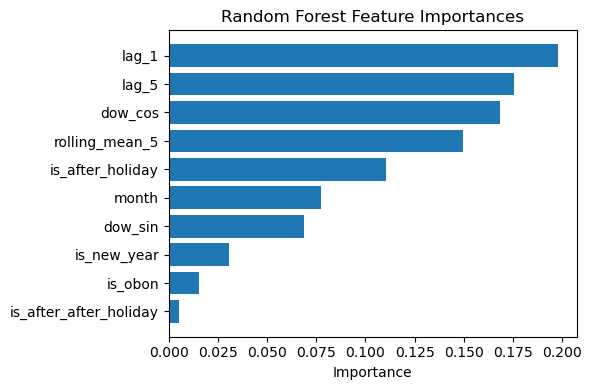

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pandas.tseries.offsets import BDay

# ------------------------------------------------------------------------------
# 0. 前提：df に必要な特徴量と '通常物数' が用意済み
# ------------------------------------------------------------------------------
feature_columns = [
    'dow_sin', 'dow_cos',   
    'is_after_holiday',
    'is_after_after_holiday',
    'month',
    'lag_1',
    'lag_5',
    'rolling_mean_5',
    'is_new_year',
    'is_obon',
]


X = df_work[feature_columns].copy()
y = df_work['通常物数'].copy()

# ------------------------------------------------------------------------------
# 1. ベースライン評価：何もチューニングせずに 5-fold 時系列CV
# ------------------------------------------------------------------------------
tscv = TimeSeriesSplit(n_splits=5)
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)

mae_list, rmse_list = [], []
for fold, (train_idx, val_idx) in enumerate(tscv.split(X), start=1):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model_rf.fit(X_tr, y_tr)
    y_pred = model_rf.predict(X_val)
    
    mae  = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae_list.append(mae)
    rmse_list.append(rmse)
    
    print(f"[Baseline] Fold {fold}: MAE = {mae:.2f}, RMSE = {rmse:.2f}")

print(f"\n[Baseline] Avg MAE = {np.mean(mae_list):.2f}, Avg RMSE = {np.mean(rmse_list):.2f}")

# ------------------------------------------------------------------------------
# 2. GridSearchCV でハイパーパラメータ最適化
# ------------------------------------------------------------------------------
param_grid = {
    'n_estimators':    [100, 300, 500],
    'max_depth':       [None, 5, 10],
    'min_samples_leaf':[1, 5, 10],
    'max_features':    ['sqrt', 'log2']
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE を目的に
    cv=tscv,
    n_jobs=-1,
    verbose=1
)
grid.fit(X, y)

print("\n===== Grid Search Result =====")
print("Best params:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)

# ------------------------------------------------------------------------------
# 3. 最適パラメータで全データ再学習
# ------------------------------------------------------------------------------
best_rf = RandomForestRegressor(
    **grid.best_params_,
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X, y)

# 自己評価
y_pred_all = best_rf.predict(X)
mae_all  = mean_absolute_error(y, y_pred_all)
rmse_all = np.sqrt(mean_squared_error(y, y_pred_all))
print(f"\n[Final Model] Training MAE: {mae_all:.2f}, RMSE: {rmse_all:.2f}")

# ------------------------------------------------------------------------------
# 4. 翌日予測
# ------------------------------------------------------------------------------
# 最後の行の特徴量を DataFrame に
# 最終学習日（営業日ラスト）を取得
last_bd = df_work.index[-1]
next_bd = last_bd + BDay(1)

# ─── 特徴量を last_bd から取り出す ───────────────────────────
lag_1           = df_work.at[last_bd, '通常物数']
lag_5           = df_work['通常物数'].shift(5).loc[last_bd]
rolling_mean_5  = df_work['通常物数'].shift(1).rolling(5).mean().loc[last_bd]

feat = {
    'dow_sin':   np.sin(2 * np.pi * next_bd.weekday() / 7),
    'dow_cos':   np.cos(2 * np.pi * next_bd.weekday() / 7),
    'is_after_holiday':       int(jpholiday.is_holiday(last_bd)),
    'is_after_after_holiday': int(jpholiday.is_holiday(last_bd - BDay(1))),
    'month':    next_bd.month,
    'lag_1':    lag_1,
    'lag_5':    lag_5,
    'rolling_mean_5': rolling_mean_5,
    'is_new_year': int(next_bd.month == 1 and next_bd.day <= 3),
    'is_obon':     int(next_bd.month == 8 and 13 <= next_bd.day <= 16),
}

X_next = pd.DataFrame([feat], index=[next_bd])

# ─── 予測 ──────────────────────────────────────────────
next_pred = model_final.predict(X_next)[0]
print(f"Next-day forecast (business day {next_bd.date()}): {next_pred:.2f}")

# ------------------------------------------------------------------------------
# 5. 特徴量重要度のプロット
# ------------------------------------------------------------------------------
importances = best_rf.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(6,4))
plt.barh([feature_columns[i] for i in idx], importances[idx])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [75]:
# XGBoostで学習、予測
import xgboost as xgb 
from xgboost import XGBRegressor

feature_columns = [
    'dow_sin', 'dow_cos',   
    'is_after_holiday',
    'is_after_after_holiday',
    'month',
    'lag_1',
    'lag_5',
    'rolling_mean_5',
    'is_new_year',
    'is_obon',
]
X = df_work[feature_columns].copy()
y = df_work['通常物数'].copy()

# 時系列CV 5分割
tscv = TimeSeriesSplit(n_splits=5)

# XGBoost モデル定義
model_xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

mae_list = []
rmse_list = []

# クロスバリデーション
for fold, (train_idx, val_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # 学習
    model_xgb.fit(X_train, y_train)
    
    # 予測
    y_pred = model_xgb.predict(X_val)
    
    # 評価指標
    mae  = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae_list.append(mae)
    rmse_list.append(rmse)
    
    print(f"Fold {fold}: MAE = {mae:.2f}, RMSE = {rmse:.2f}")

# 結果表示
print("\n===== Cross-Validation Result (TimeSeriesSplit) =====")
print(f"Average MAE : {np.mean(mae_list):.2f}")
print(f"Average RMSE: {np.mean(rmse_list):.2f}")


Fold 1: MAE = 11258.78, RMSE = 17628.56
Fold 2: MAE = 8747.64, RMSE = 15327.46
Fold 3: MAE = 9850.55, RMSE = 16914.69
Fold 4: MAE = 9390.72, RMSE = 18408.64
Fold 5: MAE = 10359.32, RMSE = 18372.19

===== Cross-Validation Result (TimeSeriesSplit) =====
Average MAE : 9921.41
Average RMSE: 17330.31


Training MAE:  6187.30
Training RMSE: 10657.62
Next-day forecast: 38726.01


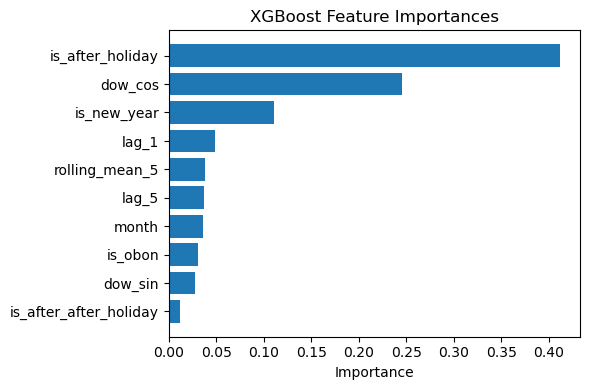

In [76]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 1. 最適パラメータでモデルを定義
best_params = {
    'n_estimators': 100,
    'learning_rate': 0.05,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'n_jobs': -1
}
model_final = XGBRegressor(**best_params)

# 2. 全データ（2021-10～2025-05）で再学習
model_final.fit(X, y)

# 3. 自己評価（全データへの予測誤差を確認）
y_pred_all = model_final.predict(X)
mae_all  = mean_absolute_error(y, y_pred_all)
rmse_all = np.sqrt(mean_squared_error(y, y_pred_all))
print(f"Training MAE:  {mae_all:.2f}")
print(f"Training RMSE: {rmse_all:.2f}")

# 4. 翌日（最終行の次）予測
#    df_feat など最終特徴量を持つ DataFrame からラスト行を取り出す
X_next = X.tail(1)
next_pred = model_final.predict(X_next)[0]
print(f"Next-day forecast: {next_pred:.2f}")

# 5. 特徴量重要度の可視化
importances = model_final.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(6,4))
plt.barh([feature_columns[i] for i in idx], importances[idx])
plt.xlabel("Importance")
plt.title("XGBoost Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


/Users/hiraokatatsuru/miniconda3/envs/shift_builder/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-08 12:59:08,529] A new study created in memory with name: no-name-0ce7e33b-88b9-4f10-81dc-ba676f969748
[I 2025-06-08 12:59:09,512] Trial 0 finished with value: 10194.3849609375 and parameters: {'n_estimators': 103, 'learning_rate': 0.09067298093089565, 'max_depth': 6, 'subsample': 0.872349158860176, 'colsample_bytree': 0.9366375371334243, 'gamma': 0.7590922567859892, 'reg_alpha': 2.1609787743742535e-07, 'reg_lambda': 2.183872095558155e-05}. Best is trial 0 with value: 10194.3849609375.
[I 2025-06-08 12:59:10,328] Trial 1 finished with value: 9739.046484375 and parameters: {'n_estimators': 124, 'learning_rate': 0.06005721124043527, 'max_depth': 4, 'subsample': 0.6580331804761812, 'colsample_bytr

===== Optuna Result =====
Best params: {'n_estimators': 183, 'learning_rate': 0.01581984530388437, 'max_depth': 6, 'subsample': 0.7282688397811246, 'colsample_bytree': 0.930742979478999, 'gamma': 2.1599100558446622, 'reg_alpha': 1.1475713121616192e-07, 'reg_lambda': 0.00014414700687716926}
Best CV MAE: 9503.684765625

Full-data Training MAE: 6000.62
Next-day forecast: 39749.99


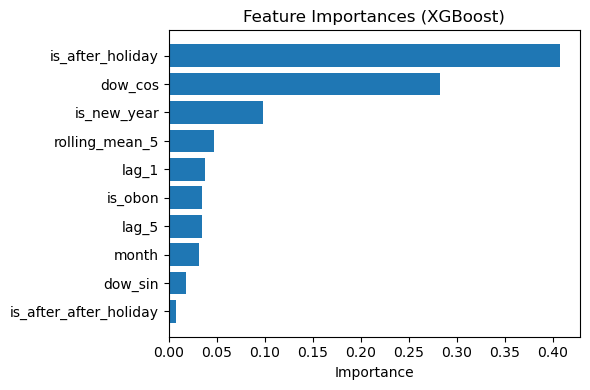

In [77]:
import numpy as np
import pandas as pd
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# 1. データ & 特徴量準備
# ------------------------------------------------------------------------------
# ここでは df_weekday が前提。すでに必要なフラグ／ラグ列が入っているものとします。
feature_columns = [
    'dow_sin', 'dow_cos',   
    'is_after_holiday',
    'is_after_after_holiday',
    'month',
    'lag_1',
    'lag_5',
    'rolling_mean_5',
    'is_new_year',
    'is_obon',
]
X = df_work[feature_columns].copy()
y = df_work['通常物数'].copy()

# ------------------------------------------------------------------------------
# 2. TimeSeriesSplit (5分割)
# ------------------------------------------------------------------------------
tscv = TimeSeriesSplit(n_splits=5)

# ------------------------------------------------------------------------------
# 3. Optuna 目的関数定義
# ------------------------------------------------------------------------------
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 10.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'objective': 'reg:squarederror',
    }
    mae_scores = []
    for train_idx, val_idx in tscv.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model = XGBRegressor(**params)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        mae_scores.append(mean_absolute_error(y_val, y_pred))
    return float(np.mean(mae_scores))

# ------------------------------------------------------------------------------
# 4. スタディ実行
# ------------------------------------------------------------------------------
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)

print("===== Optuna Result =====")
print("Best params:", study.best_params)
print("Best CV MAE:", study.best_value)

# ------------------------------------------------------------------------------
# 5. 最適モデルで全データ再学習＆自己評価
# ------------------------------------------------------------------------------
best_params = study.best_params
best_params.update({
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror',
})
model_final = XGBRegressor(**best_params)
model_final.fit(X, y)

y_pred_all = model_final.predict(X)
mae_all = mean_absolute_error(y, y_pred_all)
print(f"\nFull-data Training MAE: {mae_all:.2f}")

# ------------------------------------------------------------------------------
# 6. 翌日予測
# ------------------------------------------------------------------------------
X_next = X.tail(1)
next_pred = model_final.predict(X_next)[0]
print(f"Next-day forecast: {next_pred:.2f}")

# ------------------------------------------------------------------------------
# 7. 特徴量重要度のプロット
# ------------------------------------------------------------------------------
importances = model_final.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(6,4))
plt.barh([feature_columns[i] for i in idx], importances[idx])
plt.xlabel("Importance")
plt.title("Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
